In [88]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from skorch import NeuralNetClassifier
from torch.utils.data import random_split
from skorch.helper import SliceDataset
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets

Length of Train Data : 1139
Length of Validation Data : 284
[2 2 1 ... 3 1 3]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Starting epoch 1
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
Loss after mini-batch     1: 0.003
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Starting epoch 2
tensor([0, 3, 0, 3, 0, 0, 3, 3, 0, 0, 0, 3, 0, 3, 0, 0, 3, 0, 3, 3, 0, 0, 3, 0,
        0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 3, 3, 0, 3, 0, 3, 3, 0, 0, 3, 3, 3, 3, 3,
        0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

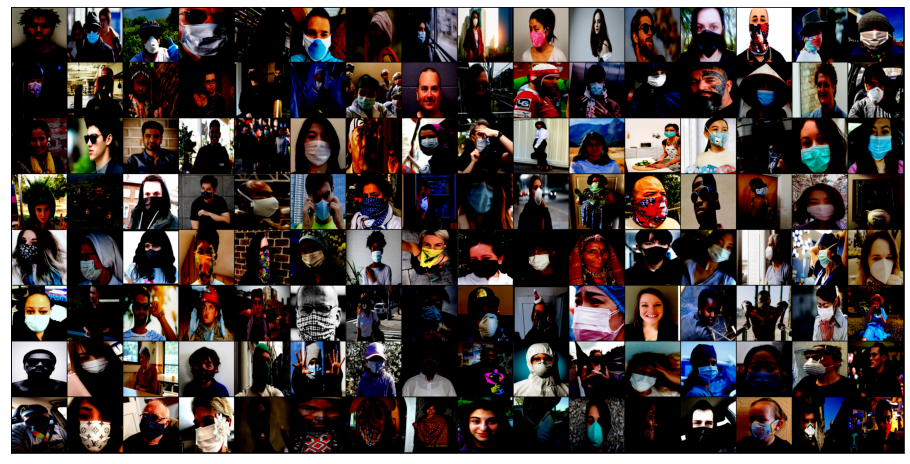

In [94]:
device = torch.device("cpu")


#normalizing
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])
cx
all_dataset = datasets.ImageFolder(
    root='input/masks/train',transform = transform)

m = len(all_dataset)
batch_size = 128

train_data,val_data = random_split(all_dataset,[int(m - m * 0.2)+1, int(m * 0.2)])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

y_train = np.array([y for x, y in iter(train_data)])

print(y_train)


def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)    


class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,4)
        )
    
    def forward(self, xb):
        return self.network(xb)
torch.manual_seed(42)

# Prepare CIFAR-10 dataset
dataset = all_dataset
trainloader = train_dl

# Initialize the ConvNet
convnet = NaturalSceneClassification()

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convnet.parameters(), lr=1e-4)

# Run the training loop
for epoch in range(0, 5): # 5 epochs at maximum

    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

        # Get inputs
        inputs, targets = data

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = convnet(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        print(i)
        if i % 20 == 0:
            print('Loss after mini-batch %5d: %.3f' %
            (i + 1, current_loss / 500))
            current_loss = 0.0

        # Process is complete.
        print('Training process has finished.')

In [97]:
def evaluate(loader):
    for i, data in enumerate(loader, 0):

        # Get inputs
        inputs, targets = data

        # Perform forward pass
        outputs = convnet(inputs)
        _, preds = torch.max(outputs, dim = 1)
        return preds
    
@torch.no_grad()
def stats(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)    

stats(convnet,val_dl)
    

{'val_loss': 1.252949595451355, 'val_acc': 0.4626116156578064}

In [91]:
result = evaluate(val_dl)

In [92]:
for p in result:
    
    print(dataset.classes[p.item()])

surgical (procedural) mask
surgical (procedural) mask
Person without a face mask
(cloth) face mask
Person without a face mask
(cloth) face mask
(cloth) face mask
(cloth) face mask
(cloth) face mask
(cloth) face mask
(cloth) face mask
(cloth) face mask
(cloth) face mask
surgical (procedural) mask
Person without a face mask
(cloth) face mask
surgical (procedural) mask
(cloth) face mask
Person without a face mask
Person without a face mask
Person without a face mask
Person without a face mask
(cloth) face mask
Person without a face mask
(cloth) face mask
Person without a face mask
Person without a face mask
Person without a face mask
surgical (procedural) mask
(cloth) face mask
surgical (procedural) mask
Person without a face mask
Person without a face mask
surgical (procedural) mask
Person without a face mask
Person without a face mask
Person without a face mask
(cloth) face mask
Person without a face mask
Person without a face mask
(cloth) face mask
(cloth) face mask
Person without a fa

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


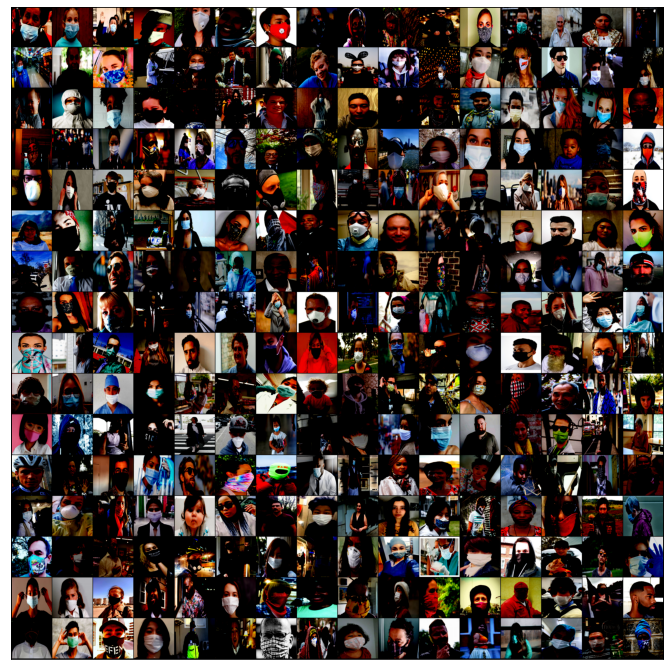

In [93]:
show_batch(val_dl)    